commands for downloading and processing dataset from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#! pip install -q kaggle

In [3]:
#from google.colab import files
#files.upload()

In [4]:
#!mkdir ~/.kaggle

In [5]:
#! cp kaggle.json ~/.kaggle/

In [6]:
#! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

In [8]:
#%cd /content/drive/MyDrive/DogBreedCLF
#!pwd
#!mkdir dataset
#! unzip stanford-dogs-dataset.zip -d dataset

**Code** (run from here down)

In [9]:
import numpy as np
import os
import cv2
import glob
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
from tensorflow import keras


os.chdir('/content/drive/MyDrive/DogBreedCLF/dataset/images/Images')
base = os.getcwd()
data_dir = pathlib.Path(base)

20580 




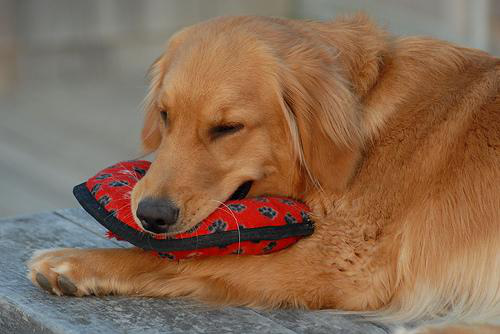

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, '\n\n')

golden = list(data_dir.glob('n02099601-golden_retriever/*'))
PIL.Image.open(str(golden[0]))

In [11]:
batch_size = 16
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

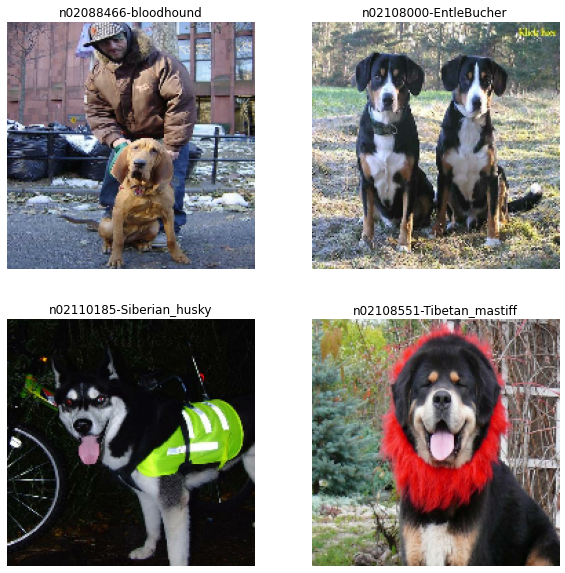

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.046459533 1.0


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
from keras import applications
from tensorflow import keras
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Rescaling

num_classes = len(class_names)

Xception = applications.Xception(include_top= False, input_shape= (img_width, img_height, 3), weights= 'imagenet')
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [18]:
model = keras.Sequential()

for layer in Xception.layers:
    layer.trainable= False
    
model.add(Xception)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'Xception_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks = [checkpoint]
  )

Epoch 1/5
1029/1029 [==============================] - ETA: 0s - loss: 3.4272 - accuracy: 0.2676
Epoch 1: val_loss improved from inf to 2.04772, saving model to Xception_model.h5
1029/1029 [==============================] - 90s 76ms/step - loss: 3.4272 - accuracy: 0.2676 - val_loss: 2.0477 - val_accuracy: 0.6370
Epoch 2/5
1028/1029 [============================>.] - ETA: 0s - loss: 1.7513 - accuracy: 0.6042
Epoch 2: val_loss improved from 2.04772 to 1.32481, saving model to Xception_model.h5
1029/1029 [==============================] - 59s 57ms/step - loss: 1.7511 - accuracy: 0.6042 - val_loss: 1.3248 - val_accuracy: 0.6990
Epoch 3/5
1028/1029 [============================>.] - ETA: 0s - loss: 1.2912 - accuracy: 0.6719
Epoch 3: val_loss improved from 1.32481 to 1.10036, saving model to Xception_model.h5
1029/1029 [==============================] - 58s 57ms/step - loss: 1.2912 - accuracy: 0.6718 - val_loss: 1.1004 - val_accuracy: 0.7172
Epoch 4/5
1029/1029 [=============================

In [20]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks = [checkpoint]
  )

Epoch 1/10
1029/1029 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.7349
Epoch 1: val_loss improved from 0.95169 to 0.92090, saving model to Xception_model.h5
1029/1029 [==============================] - 59s 57ms/step - loss: 0.9303 - accuracy: 0.7349 - val_loss: 0.9209 - val_accuracy: 0.7398
Epoch 2/10
1029/1029 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.7421
Epoch 2: val_loss improved from 0.92090 to 0.90134, saving model to Xception_model.h5
1029/1029 [==============================] - 59s 57ms/step - loss: 0.8858 - accuracy: 0.7421 - val_loss: 0.9013 - val_accuracy: 0.7425
Epoch 3/10
1029/1029 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.7487
Epoch 3: val_loss improved from 0.90134 to 0.88947, saving model to Xception_model.h5
1029/1029 [==============================] - 58s 56ms/step - loss: 0.8549 - accuracy: 0.7487 - val_loss: 0.8895 - val_accuracy: 0.7427
Epoch 4/10
1029/1029 [=====================

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks = [checkpoint]
  )

Epoch 1/10
1029/1029 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.7941
Epoch 1: val_loss improved from 0.85944 to 0.85859, saving model to Xception_model.h5
1029/1029 [==============================] - 59s 57ms/step - loss: 0.6776 - accuracy: 0.7941 - val_loss: 0.8586 - val_accuracy: 0.7507
Epoch 2/10
1029/1029 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7968
Epoch 2: val_loss improved from 0.85859 to 0.85745, saving model to Xception_model.h5
1029/1029 [==============================] - 58s 57ms/step - loss: 0.6694 - accuracy: 0.7968 - val_loss: 0.8575 - val_accuracy: 0.7510
Epoch 3/10
1028/1029 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.8006
Epoch 3: val_loss did not improve from 0.85745
1029/1029 [==============================] - 57s 56ms/step - loss: 0.6469 - accuracy: 0.8006 - val_loss: 0.8583 - val_accuracy: 0.7517
Epoch 4/10
1028/1029 [============================>.] - ETA: 0s - loss: 0.6402 - a

In [22]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks = [checkpoint]
  )

Epoch 1/5
1029/1029 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.8254
Epoch 1: val_loss did not improve from 0.85745
1029/1029 [==============================] - 57s 56ms/step - loss: 0.5624 - accuracy: 0.8254 - val_loss: 0.8631 - val_accuracy: 0.7512
Epoch 2/5
1028/1029 [============================>.] - ETA: 0s - loss: 0.5538 - accuracy: 0.8276
Epoch 2: val_loss did not improve from 0.85745
1029/1029 [==============================] - 57s 55ms/step - loss: 0.5538 - accuracy: 0.8277 - val_loss: 0.8636 - val_accuracy: 0.7529
Epoch 3/5
1028/1029 [============================>.] - ETA: 0s - loss: 0.5489 - accuracy: 0.8279
Epoch 3: val_loss did not improve from 0.85745
1029/1029 [==============================] - 57s 55ms/step - loss: 0.5490 - accuracy: 0.8279 - val_loss: 0.8648 - val_accuracy: 0.7522
Epoch 4/5
1028/1029 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.8351
Epoch 4: val_loss did not improve from 0.85745
1029/1029 [========

In [24]:
loss, acc = model.evaluate(val_ds, batch_size= batch_size)
print(f'Validation Accuracy: {round((acc * 100), 2)}%')

258/258 [==============================] - 12s 45ms/step - loss: 0.8669 - accuracy: 0.7522
Validation Accuracy: 75.22%


In [25]:
os.getcwd()


'/content/drive/MyDrive/DogBreedCLF/dataset/images/Images'

1/1 [==============================] - 0s 38ms/step
predicted: toy poodle


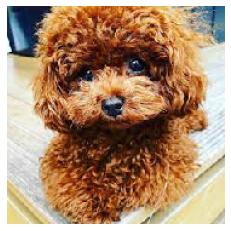

In [48]:
def display_img(img):
   plt.axis("off")
   plt.imshow(img)
   

def get_image_prediction(path):
  img = tf.keras.preprocessing.image.load_img(path, color_mode="rgb", target_size=(img_width, img_height, 3))
  img_arr = (tf.keras.preprocessing.image.img_to_array(img))/255
  img_arr = np.array([img_arr])
  display_img(img)
  predictions = model.predict(img_arr)
  label = np.argmax(predictions, axis=-1)
  return np.squeeze(label)

def get_class_name(label_index):
  name_str = (class_names[label_index]).split('-')[1]
  return name_str.replace('_', ' ')


index = get_image_prediction('/content/drive/MyDrive/DogBreedCLF/od_test/toy_poole.jfif')
predicted_breed = get_class_name(index)
print(f'predicted: {predicted_breed}')